<a href="https://colab.research.google.com/github/hectorcamachoz/LDA_Arboles_de_Decisiones/blob/main/A2_2_594557.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LDA y Árboles de Decisiones

El objetivo de esta actividad es realizar una comparacion entre un modelo de LinearDiscriminantAnalysis y uno utilizando Árboles de Decisión, utilizando una base de datos llamada 'day.csv' recopilada de UCI Machine Learning Repository. Las variables que estan en la base de datos, son las siguientes:

- dteday - Dia
- season - Temporada
- yr - Año
- mnth - Mes
- holiday - Festividad
- weekday - Dia entre semana
- workingday - Dia laboral
- weathersit - Clima
- temp - Temperatura (°C)
- atemp - Sensacion termica
- hum - Humeadad
- windspeed - Velocidad del aire
- casual - Usuarios Casuales
- registered - Usuarios Registrados
- cnt - bicicletas rentadas en un dia
- renta_del_dia -
  - Caso 1: Se rentan 2500 bicis o mas en un dia
  - Caso 0: Se rentan menos de 2500 bicis.


1. Se utilizara la base de datos del repositorio llamado Proyecto_1_InteligenciaArtificial, por lo tanto, se aplicaran todas las modificaciones que se hicieron a la base de datos en esa actividad, si quisieras conocer el porque de cada modificacion, lo podras encontrar en el repositorio mencionado.

  Para comenzar se importaran los datos y se hara una particion 80 - 20 manteniendo un balance en las clases.

In [91]:
import pandas as pd

df = pd.read_csv('day.csv')
df = df.drop('instant', axis=1)
df = df.drop('dteday', axis= 1)
df = df.drop('mnth', axis = 1)
df = df.drop('weekday', axis=1)
df = pd.get_dummies(df, columns=['season', 'weathersit'],drop_first=False, dtype = int)
df = df.drop('atemp', axis = 1)

df = df.drop('casual', axis = 1)
df = df.drop('registered', axis = 1)

renta_del_dia = []

for i in df['cnt']:
    if i >= 2500:
        renta_del_dia.append(1)
    else:
        renta_del_dia.append(0)
df = pd.concat([df, pd.Series(renta_del_dia, name='renta_del_dia')], axis=1)
df = df.drop('cnt', axis = 1)
df.head()

print(df.renta_del_dia.value_counts())

x = df.drop('renta_del_dia', axis = 1)
y = df['renta_del_dia']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 42)

print("Distribución en y:\n", y.value_counts(normalize=True))
print("\nDistribución en y_train:\n", y_train.value_counts(normalize=True))
print("\nDistribución en y_test:\n", y_test.value_counts(normalize=True))

renta_del_dia
1    587
0    144
Name: count, dtype: int64
Distribución en y:
 renta_del_dia
1    0.80301
0    0.19699
Name: proportion, dtype: float64

Distribución en y_train:
 renta_del_dia
1    0.803082
0    0.196918
Name: proportion, dtype: float64

Distribución en y_test:
 renta_del_dia
1    0.802721
0    0.197279
Name: proportion, dtype: float64


2. A continuacion se utilizara la funcion GLM de la libreria statsmodels, para realizar una regresion logistica simple para detectar cuales son las dos variables mas relevantes.


In [92]:
import statsmodels.api as sm
md_glm = sm.GLM(y_train, sm.add_constant(x_train), family=sm.families.Binomial())
res_glm = md_glm.fit()
print(res_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          renta_del_dia   No. Observations:                  584
Model:                            GLM   Df Residuals:                      572
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -86.929
Date:                Thu, 20 Mar 2025   Deviance:                       173.86
Time:                        05:08:45   Pearson chi2:                     979.
No. Iterations:                     8   Pseudo R-squ. (CS):             0.5007
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.8477      1.053     -2.704   

Al observar los resultados del generalized linear model, podemos concluir que este modelo se ajusta al 50% de los datos. De acuerdo a chatGPT, otra de las formas para medir la calidad del modelo es con el Log-Likelihood, entre mas cercana a 0 mejor, en este caso dio como resultado -86.9. Para seleccionar las dos variables mas siginificativas, se tomara en cuenta el P-value, por lo tanto se eligira la variable yr (año) y la variable de temp (Temperatura).

In [93]:
x_train_f = x_train.filter(items=['yr', 'temp'])
x_test_f = x_test.filter(items=['yr', 'temp'])


3. Se generara otro modelo, esta vez utilizando la funcion LinearDiscriminantAnalysis de sklearn.discriminant_analysis, y se realizara una grafica para una observacion mas sencilla

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(


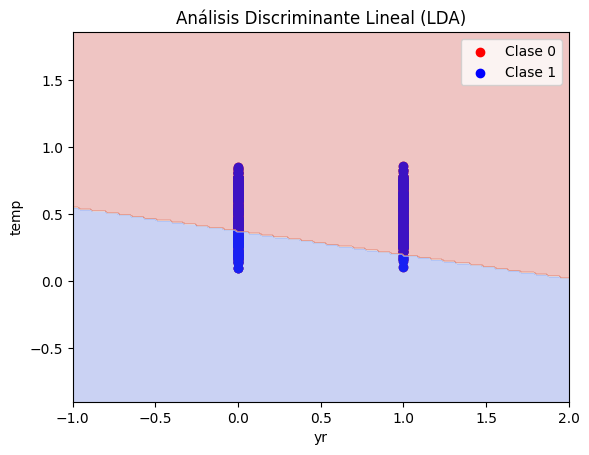

In [94]:
import sklearn.discriminant_analysis as LDA
import matplotlib.pyplot as plt
import numpy as np

colors = {0: 'red', 1: 'blue'}
md_LDA = LDA.LinearDiscriminantAnalysis()
md_LDA.fit(x_train_f, y_train)
y_pred_proba = md_LDA.predict_proba(x_test_f)
y_pred = md_LDA.predict(x_test_f)
for clase in np.unique(y):
    plt.scatter(x_train_f['yr'],
                x_train_f['temp'],
                color=colors[clase],
                label=f'Clase {clase}')


x_min, x_max = x_train_f['yr'].min() - 1, x_train_f['yr'].max() + 1
y_min, y_max = x_train_f['temp'].min() - 1, x_train_f['temp'].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
Z = md_LDA.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

plt.xlabel('yr')
plt.ylabel('temp')
plt.title('Análisis Discriminante Lineal (LDA)')
plt.legend()
plt.show()

4. A continuacion se generara un modelo por medio de la metodologia de árboles de decisión, utilizando tambien el LOOCV para determinar el valor de alfa adecuado para la poda de arbol. Esto se realizara en una segunda particion de datos, para asi evitar una fuga de datos.

Para crear la grafica de particion del espacio me ayude de ChatGPT

El mejor valor de alpha es: 0.0040


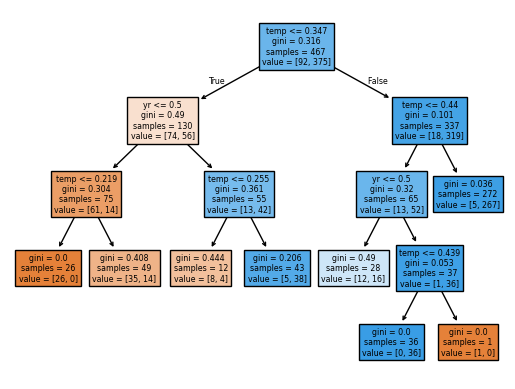

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


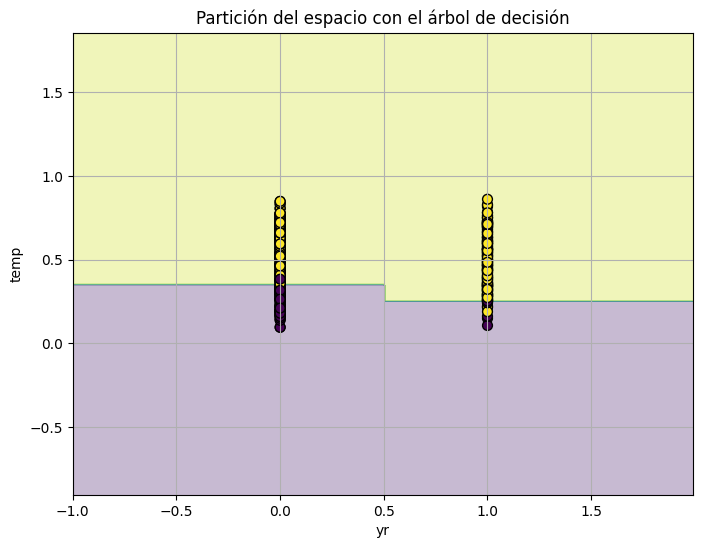

In [95]:
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.model_selection import LeaveOneOut
X = x_train_f.reset_index(drop=True)
y = y_train.reset_index(drop=True)

x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(X,y, test_size = 0.2, stratify = y, random_state = 42)

loo = LeaveOneOut()
alphas = np.linspace(0.001, 0.02, 20)

alpha_scores = []

for alpha in alphas:
    accuracies = []

    model = DTC(ccp_alpha=alpha, random_state=42)
    model.fit(x_train_2, y_train_2)


    y_pred_loo = model.predict(x_test_2)
    accuracies.append(accuracy_score(y_test_2, y_pred_loo))

    alpha_scores.append(np.mean(accuracies))

best_alpha = alphas[np.argmax(alpha_scores)]

print(f"El mejor valor de alpha es: {best_alpha:.4f}")

model = DTC(ccp_alpha=best_alpha, random_state=42)
model.fit(x_train_2, y_train_2)
y_pred_loo = model.predict(x_test_2)
plot_tree(model, filled=True,feature_names=x_train_2.columns);
plt.show()


x_min, x_max = x_train_2.iloc[:, 0].min() - 1, x_train_2.iloc[:, 0].max() + 1
y_min, y_max = x_train_2.iloc[:, 1].min() - 1, x_train_2.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(x_train_2.iloc[:, 0], x_train_2.iloc[:, 1], c=y_train_2, cmap='viridis', edgecolor='k', s=50)
plt.title("Partición del espacio con el árbol de decisión")
plt.xlabel('yr')
plt.ylabel('temp')
plt.grid(True)
plt.show()

Se puede observar que quedo un árbol de pocas ramas, y es relativamente facil de interpretaer. Y en el grafico de particion del espacio, se puede concluir que si el dia tenia una temperatura menor a 0.4, en ambos años, en el dia se rentaban mas de 2500 bicicletas.

5. Para finalizar esta actividad, se calcularan las siguientes metricas para cada modelo:
- Accuracy
- Specificity
- Sensitivity
- Precision
- F1-Score

Esto con el objetivo de determinar cual modelo es mejor, si el elaborado con LDA o el de Árbol de decisión.

In [96]:
import sklearn.metrics as metrics
accuracy_LDA = accuracy_score(y_test, y_pred)
accuracy_DT = accuracy_score(y_test_2, y_pred_loo)

specificity_LDA = metrics.recall_score(y_test, y_pred, pos_label=0)
specificity_DT = metrics.recall_score(y_test_2, y_pred_loo, pos_label=0)

sensitivity_LDA = metrics.recall_score(y_test, y_pred, pos_label=1)
sensitivity_DT = metrics.recall_score(y_test_2, y_pred_loo, pos_label=1)

precision_LDA = metrics.precision_score(y_test, y_pred)
precision_DT = metrics.precision_score(y_test_2, y_pred_loo)

f1_score_LDA = metrics.f1_score(y_test, y_pred)
f1_score_DT = metrics.f1_score(y_test_2, y_pred_loo)

print("LDA:")
print("Accuracy:", accuracy_LDA)
print("Specificity:", specificity_LDA)
print("Sensitivity:", sensitivity_LDA)
print("Precision:", precision_LDA)
print("F1-Score:", f1_score_LDA)

print("\nÁrbol de Decisión:")
print("Accuracy:", accuracy_DT)
print("Specificity:", specificity_DT)
print("Sensitivity:", sensitivity_DT)
print("Precision:", precision_DT)
print("F1-Score:", f1_score_DT)


LDA:
Accuracy: 0.8571428571428571
Specificity: 0.4827586206896552
Sensitivity: 0.9491525423728814
Precision: 0.8818897637795275
F1-Score: 0.9142857142857143

Árbol de Decisión:
Accuracy: 0.9316239316239316
Specificity: 0.8260869565217391
Sensitivity: 0.9574468085106383
Precision: 0.9574468085106383
F1-Score: 0.9574468085106383


Para comenzar el analisis de los resultados, se sabe que la metrica de F1-Score es dificil de interpretar, sin embargo, es sabido que entre mas cercana a 1 mejor, por lo tanto se puede concluir que el modelo con mejor **F1-Score** es el de Árbol de Decisión.

El **Accuracy** indica la proporcion de predicciones totales que fueron correctas, en este caso el modelo LDA cuenta con un Accuracy de 0.85 y el modelo DT cuenta con 0.93, por lo tanto, se puede decir que el modelo de Árbol de Decisión cuenta con una mejor exactitud.

El **Specificity** o **Especificidad** en español, es la proporcion de los casos negativos que fueron correctamente predichos, es decir, la proporcion de clase 0 que fueron predichos correctamente. En este caso el modelo LDA cuenta con un valor de 0.48, y en el modelo DT es de 0.82, con estos datos se puede concluir que el modelo DT cuenta con una mejor especificidad.

La **Sensibilidad** o **Sensitivity**, es la proporcion de casos 1 que fueron correctamente predichos. El modelo LDA cuenta con un valor de 0.949, y el modelo DT de 0.957, a pesar de ser valores muy cercanos, el modelo con mejor sensibilidad es el de Árbol de decision.

Por ultimo, **Presicion** o **Precision** en ingles, es la proporcion de predicciones en el caso 1 que fueron correctas. En este caso el modelo LDA cuenta con un valor de 0.88 y el modelo DT con un valor de 0.957.

Con esto se puede concluir que el modelo de Árboles de Decisión fue mucho mejor al modelo de LinearDiscriminantAnalysis.